In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [3]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [4]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

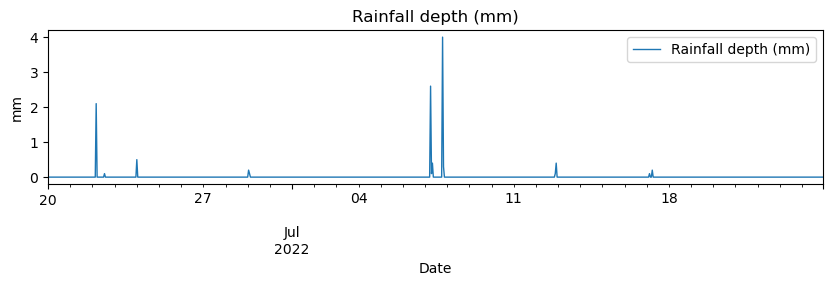

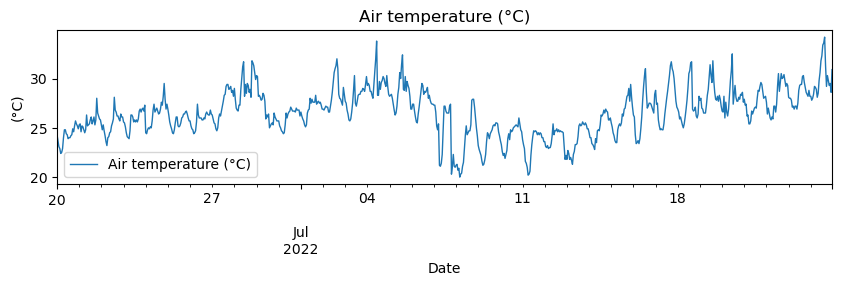

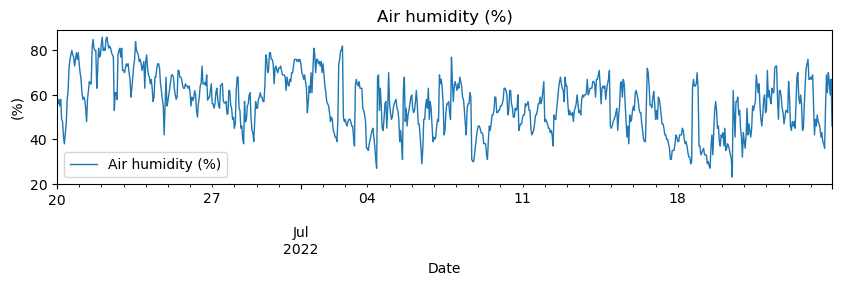

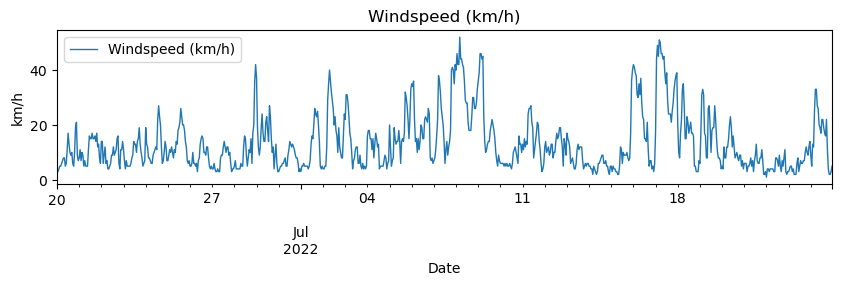

In [5]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-06-20'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96550D+00    |proj g|=  1.43505D-01


 This problem is unconstrained.



At iterate    5    f=  1.91718D+00    |proj g|=  3.67019D-01

At iterate   10    f=  1.89324D+00    |proj g|=  7.57110D-02

At iterate   15    f=  1.88285D+00    |proj g|=  1.36297D-02

At iterate   20    f=  1.88231D+00    |proj g|=  6.32791D-03

At iterate   25    f=  1.88215D+00    |proj g|=  5.71124D-03

At iterate   30    f=  1.88210D+00    |proj g|=  2.89295D-03

At iterate   35    f=  1.88193D+00    |proj g|=  1.18296D-02

At iterate   40    f=  1.88188D+00    |proj g|=  6.83429D-03

At iterate   45    f=  1.88186D+00    |proj g|=  2.18543D-03

At iterate   50    f=  1.88186D+00    |proj g|=  2.81791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

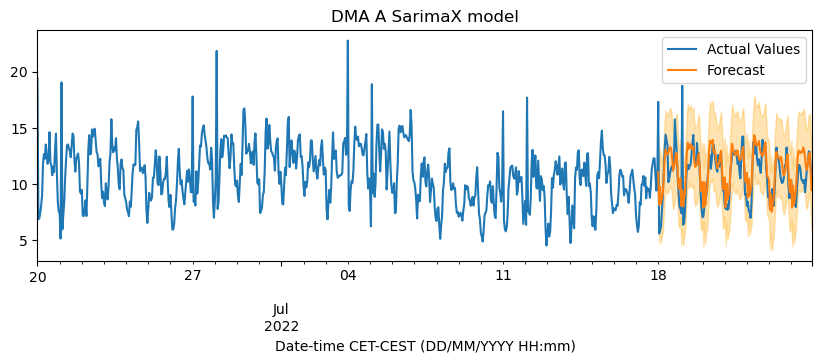

Performance indicators
DMA A SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.66            6.25             1.05           8.96 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.40            6.55             1.72           10.67 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04171D+00    |proj g|=  4.34506D-01


 This problem is unconstrained.



At iterate    5    f=  1.00753D+00    |proj g|=  1.55526D-01

At iterate   10    f=  9.89209D-01    |proj g|=  3.64182D-01

At iterate   15    f=  9.69341D-01    |proj g|=  3.06111D-02

At iterate   20    f=  9.68204D-01    |proj g|=  2.08086D-02

At iterate   25    f=  9.66036D-01    |proj g|=  2.99021D-01

At iterate   30    f=  9.63900D-01    |proj g|=  1.44866D-01

At iterate   35    f=  9.63028D-01    |proj g|=  9.26059D-03

At iterate   40    f=  9.62836D-01    |proj g|=  1.34473D-02

At iterate   45    f=  9.62780D-01    |proj g|=  3.13575D-03

At iterate   50    f=  9.62758D-01    |proj g|=  5.34088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

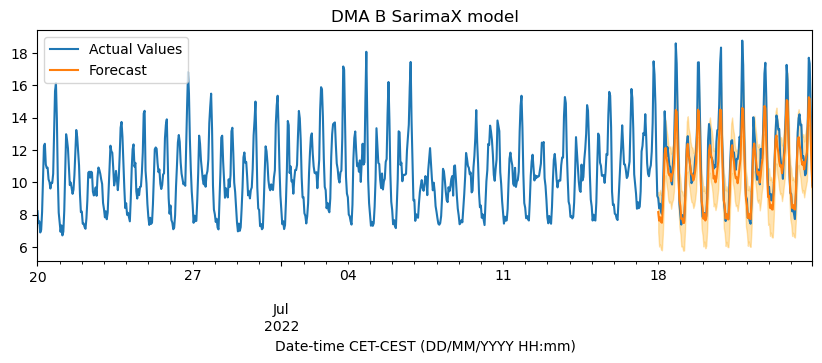

Performance indicators
DMA B SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.14            4.11             0.84           6.10 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.22            8.16             2.25           12.64 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68552D-01    |proj g|=  1.08792D+00


 This problem is unconstrained.



At iterate    5    f=  8.20800D-01    |proj g|=  2.81390D-01

At iterate   10    f=  8.09383D-01    |proj g|=  7.37599D-01

At iterate   15    f=  7.84299D-01    |proj g|=  3.38224D-02

At iterate   20    f=  7.77979D-01    |proj g|=  8.42281D-02

At iterate   25    f=  7.77162D-01    |proj g|=  1.25077D-01

At iterate   30    f=  7.76069D-01    |proj g|=  2.70601D-02

At iterate   35    f=  7.75768D-01    |proj g|=  2.11735D-02

At iterate   40    f=  7.75716D-01    |proj g|=  1.85635D-02

At iterate   45    f=  7.75665D-01    |proj g|=  1.23453D-02

At iterate   50    f=  7.75608D-01    |proj g|=  2.39436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

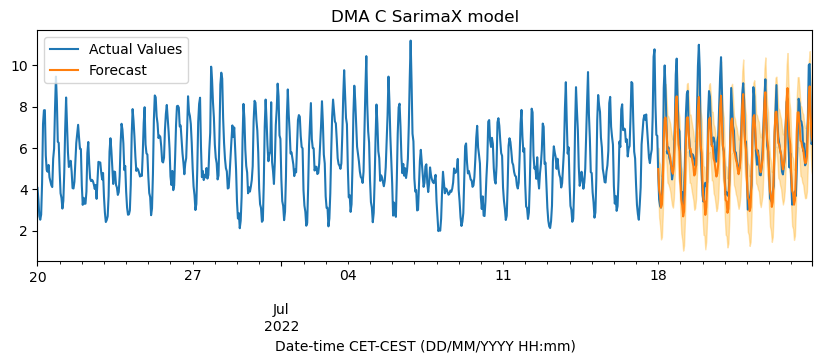

Performance indicators
DMA C SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.72            2.58             0.60           3.91 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.75            4.92             1.52           8.20 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43052D+00    |proj g|=  9.50033D-02


 This problem is unconstrained.



At iterate    5    f=  2.36745D+00    |proj g|=  4.35756D-01

At iterate   10    f=  2.34420D+00    |proj g|=  5.01536D-02

At iterate   15    f=  2.33323D+00    |proj g|=  6.59876D-03

At iterate   20    f=  2.33191D+00    |proj g|=  1.72671D-02

At iterate   25    f=  2.33179D+00    |proj g|=  3.34064D-03

At iterate   30    f=  2.33172D+00    |proj g|=  2.07506D-03

At iterate   35    f=  2.33164D+00    |proj g|=  2.60604D-03

At iterate   40    f=  2.33160D+00    |proj g|=  2.10355D-03

At iterate   45    f=  2.33159D+00    |proj g|=  4.75616D-03

At iterate   50    f=  2.33158D+00    |proj g|=  1.81920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

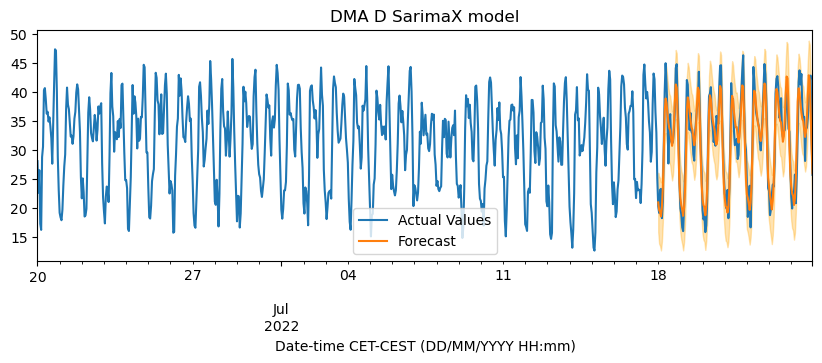

Performance indicators
DMA D SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.35            7.08             2.26           11.69 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.79            13.65             6.69           27.12 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21230D+00    |proj g|=  2.19710D-01


 This problem is unconstrained.



At iterate    5    f=  2.15265D+00    |proj g|=  1.46905D-01

At iterate   10    f=  2.13373D+00    |proj g|=  4.92988D-02

At iterate   15    f=  2.13106D+00    |proj g|=  7.92590D-03

At iterate   20    f=  2.13095D+00    |proj g|=  4.86629D-02

At iterate   25    f=  2.13079D+00    |proj g|=  5.25502D-03

At iterate   30    f=  2.13071D+00    |proj g|=  2.40351D-03

At iterate   35    f=  2.13070D+00    |proj g|=  2.86334D-03

At iterate   40    f=  2.13068D+00    |proj g|=  6.90531D-04

At iterate   45    f=  2.13068D+00    |proj g|=  2.33098D-04

At iterate   50    f=  2.13068D+00    |proj g|=  7.39547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

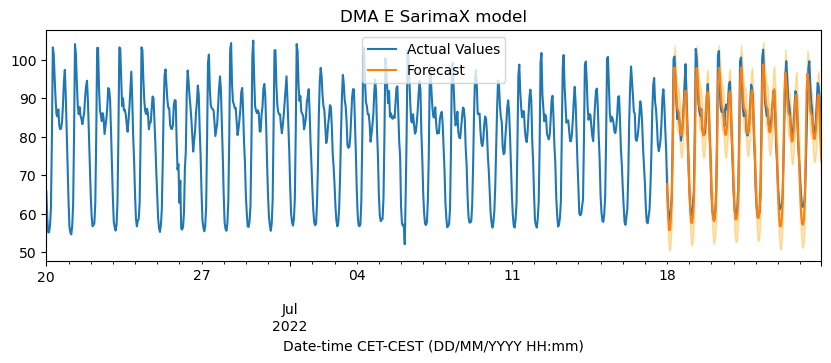

Performance indicators
DMA E SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.17            6.90             2.36           11.42 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
10.85            21.31             10.55           42.71 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60448D+00    |proj g|=  2.32176D-01


 This problem is unconstrained.



At iterate    5    f=  1.55296D+00    |proj g|=  7.43737D-02

At iterate   10    f=  1.52955D+00    |proj g|=  5.86246D-02

At iterate   15    f=  1.52073D+00    |proj g|=  4.81691D-02

At iterate   20    f=  1.52052D+00    |proj g|=  1.48067D-02

At iterate   25    f=  1.51990D+00    |proj g|=  1.67587D-02

At iterate   30    f=  1.51981D+00    |proj g|=  2.05389D-03

At iterate   35    f=  1.51965D+00    |proj g|=  7.79080D-03

At iterate   40    f=  1.51963D+00    |proj g|=  1.91315D-03

At iterate   45    f=  1.51960D+00    |proj g|=  1.38755D-02

At iterate   50    f=  1.51951D+00    |proj g|=  1.58959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

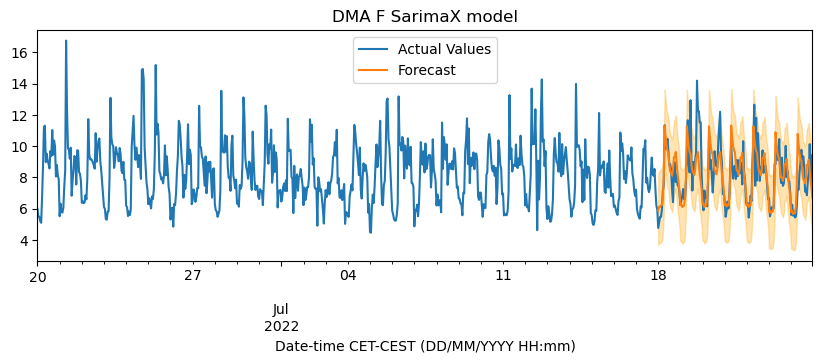

Performance indicators
DMA F SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.64            2.11             0.92           3.66 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.45            3.46             1.37           6.29 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70544D+00    |proj g|=  1.56858D-01


 This problem is unconstrained.



At iterate    5    f=  1.66576D+00    |proj g|=  1.64733D-01

At iterate   10    f=  1.63236D+00    |proj g|=  1.05567D-02

At iterate   15    f=  1.63129D+00    |proj g|=  1.31638D-02

At iterate   20    f=  1.63066D+00    |proj g|=  1.72628D-02

At iterate   25    f=  1.63024D+00    |proj g|=  1.71020D-02

At iterate   30    f=  1.63008D+00    |proj g|=  1.58062D-03

At iterate   35    f=  1.63005D+00    |proj g|=  4.46525D-03

At iterate   40    f=  1.62996D+00    |proj g|=  9.53959D-03

At iterate   45    f=  1.62985D+00    |proj g|=  7.07311D-04

At iterate   50    f=  1.62984D+00    |proj g|=  3.42980D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

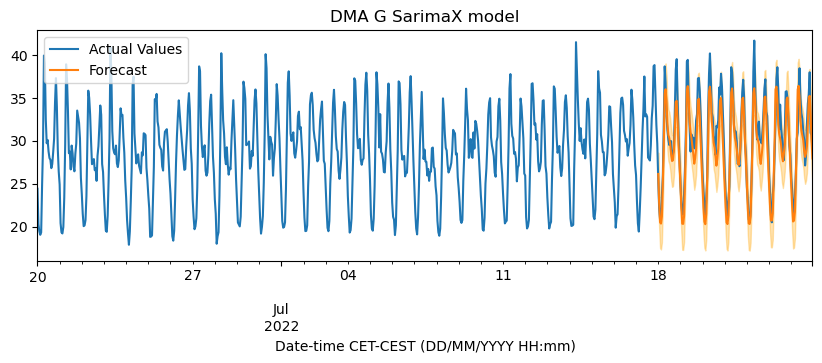

Performance indicators
DMA G SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.39            4.86             1.63           7.89 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.27            11.09             4.59           19.95 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60140D+00    |proj g|=  1.53810D-01


 This problem is unconstrained.



At iterate    5    f=  1.57267D+00    |proj g|=  9.70228D-02

At iterate   10    f=  1.52456D+00    |proj g|=  1.12767D-02

At iterate   15    f=  1.52283D+00    |proj g|=  1.99860D-02

At iterate   20    f=  1.52254D+00    |proj g|=  2.37542D-02

At iterate   25    f=  1.52250D+00    |proj g|=  8.33135D-04

At iterate   30    f=  1.52249D+00    |proj g|=  1.52497D-03

At iterate   35    f=  1.52248D+00    |proj g|=  8.36823D-03

At iterate   40    f=  1.52248D+00    |proj g|=  6.04541D-04

At iterate   45    f=  1.52247D+00    |proj g|=  1.36865D-03

At iterate   50    f=  1.52247D+00    |proj g|=  5.39120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

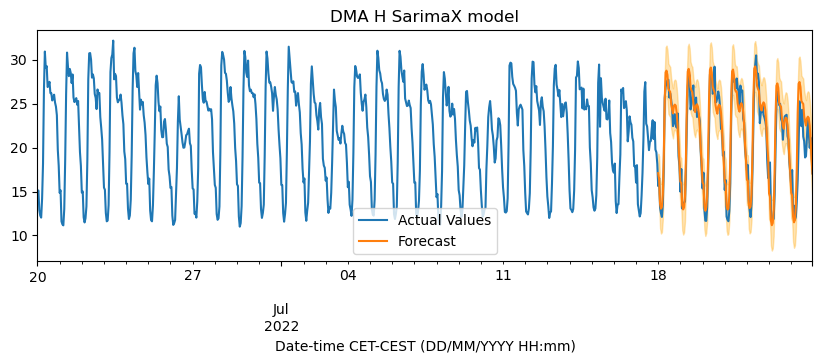

Performance indicators
DMA H SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.99            2.19             1.32           4.50 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.49            9.41             4.49           18.39 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84051D+00    |proj g|=  1.96498D-01


 This problem is unconstrained.



At iterate    5    f=  1.77020D+00    |proj g|=  2.82242D-01

At iterate   10    f=  1.75065D+00    |proj g|=  1.24703D-01

At iterate   15    f=  1.73467D+00    |proj g|=  4.29519D-02

At iterate   20    f=  1.73213D+00    |proj g|=  5.29956D-03

At iterate   25    f=  1.73147D+00    |proj g|=  4.48208D-03

At iterate   30    f=  1.73140D+00    |proj g|=  5.18803D-03

At iterate   35    f=  1.73126D+00    |proj g|=  5.96501D-03

At iterate   40    f=  1.73120D+00    |proj g|=  3.81249D-03

At iterate   45    f=  1.73110D+00    |proj g|=  1.62848D-03

At iterate   50    f=  1.73097D+00    |proj g|=  1.02761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

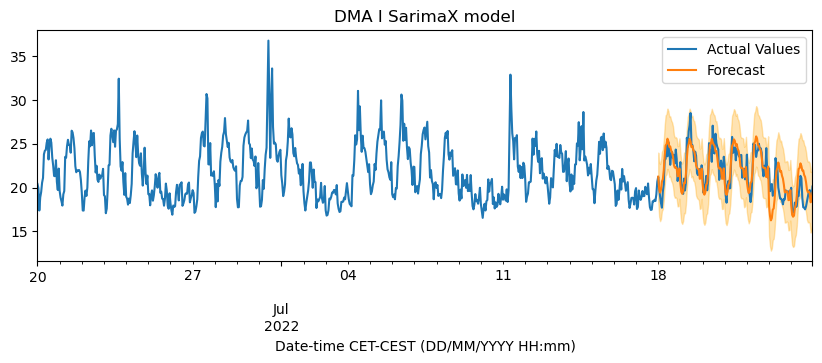

Performance indicators
DMA I SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.88            2.99             1.20           5.07 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.89            4.07             2.16           8.11 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82822D+00    |proj g|=  1.77787D-01

At iterate    5    f=  1.76411D+00    |proj g|=  1.23602D-01

At iterate   10    f=  1.73623D+00    |proj g|=  4.79226D-02

At iterate   15    f=  1.72916D+00    |proj g|=  1.73502D-02

At iterate   20    f=  1.72809D+00    |proj g|=  1.03261D-02

At iterate   25    f=  1.72755D+00    |proj g|=  1.85634D-02

At iterate   30    f=  1.72612D+00    |proj g|=  8.00506D-03

At iterate   35    f=  1.72548D+00    |proj g|=  1.92352D-02

At iterate   40    f=  1.72535D+00    |proj g|=  2.88981D-03

At iterate   45    f=  1.72512D+00    |proj g|=  2.89405D-02

At iterate   50    f=  1.72484D+00    |proj g|=  9.71053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

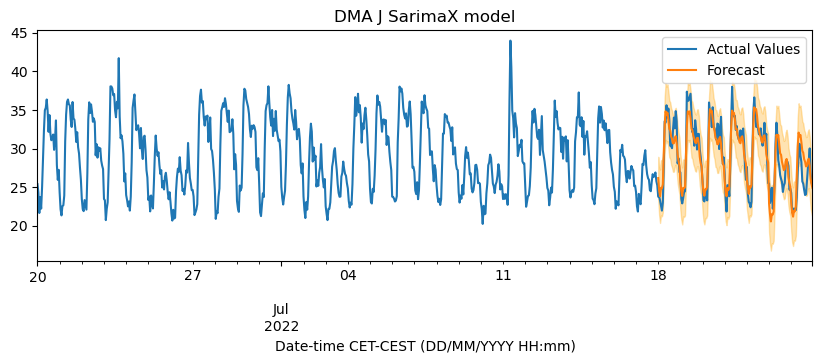

Performance indicators
DMA J SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.59            3.32             1.34           6.26 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.07            7.01             3.72           14.80 



In [6]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 4-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [7]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 4-Weeks,1.655,6.248,1.054,8.957
DMA B SarimaX 4-Weeks,1.140,4.113,0.843,6.096
DMA C SarimaX 4-Weeks,0.725,2.582,0.604,3.911
DMA D SarimaX 4-Weeks,2.345,7.084,2.258,11.687
DMA E SarimaX 4-Weeks,2.167,6.897,2.359,11.422
DMA F SarimaX 4-Weeks,0.637,2.110,0.917,3.664
DMA G SarimaX 4-Weeks,1.394,4.861,1.635,7.889
DMA H SarimaX 4-Weeks,0.989,2.194,1.319,4.502
DMA I SarimaX 4-Weeks,0.876,2.986,1.203,5.065
DMA J SarimaX 4-Weeks,1.595,3.324,1.343,6.262


In [8]:
print(f"{results_df['Total'].sum() :.2f}")

69.45


In [11]:
print(f"{results_df.drop('DMA E SarimaX 4-Weeks')['Total'].sum() :.2f}")

58.03
